In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime,timedelta
from glob import glob
import math
from scipy import interpolate
from scipy.signal import savgol_filter

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

smc_dir = r'D:\RS_DATA\SIF\物联网数据\csv\smc\\'
pre_dir = r'D:\RS_DATA\SIF\物联网数据\csv\pre\\'
outpath = r'D:\Backup\manuscript\退修2\\'
smc_list = glob(smc_dir+'*')
pre_list = glob(pre_dir+'*')

tif_list = glob(r"C:\Users\win\Desktop\NSDI\*.tif")
tif_length = len(tif_list)
dates_list = pd.date_range(start='3/30/2018',end='5/10/2019')
city = ['原阳','商丘','泰安','深州','西平']
lat = [35.014712,34.531862,35.96824,37.900735,33.29542]
lon = [113.687952,115.71006,117.088713,115.706568,114.02001]

In [2]:
'''
 根据经纬度提取图像上的像素值
'''
from osgeo import gdal
from osgeo import osr
import numpy as np

def get_file_info(in_file_path):
    '''
    根据tif路径，以只读的方式打开图像
    return：gdal数据集、地理空间坐标系、投影坐标系、栅格影像的大小相关信息
    '''
    #
    pca = None
    gcs = None
    shape = None
    #
    if in_file_path.endswith(".tif") or in_file_path.endswith(".TIF"):
        dataset = gdal.Open(in_file_path)
        pcs = osr.SpatialReference()
        pcs.ImportFromWkt(dataset.GetProjection())
        gcs = pcs.CloneGeogCS()
        extend = dataset.GetGeoTransform()
        shape = (dataset.RasterXSize,dataset.RasterYSize)
    else:
        raise("unsupported file format!")
    return dataset, gcs, pcs, extend, shape 

def lonlat_to_xy(gcs,pcs,lon,lat):
    '''
    经纬度坐标转换为投影坐标
    gcs: 地理空间坐标信息，由函数get_file_info()函数获取
    pcs: 投影坐标信息
    lon: 经度
    lat: 纬度
    return: 地理空间坐标对应的投影坐标
    '''
    #
    ct = osr.CoordinateTransformation(gcs,pcs)
    coordinates = ct.TransformPoint(lon,lat,0)
    #
    return coordinates[0],coordinates[1],coordinates[2]

def xy_to_lonlat(gcs,pcs,x,y):
    '''
    投影坐标转换为经纬度坐标
    gcs: 地理空间坐标信息，由函数get_file_info()函数获取
    pcs: 投影坐标信息
    x: 投影坐标x
    y: 投影坐标y
    return:投影坐标对应的地理空间坐标
    '''
    #
    ct = osr.CoordinatesTransformation(pcs,gcs)
    lon, lat, _ = ct.TransformPoint(x,y)
    #
    return lon,lat

def xy_to_rowcol(extend,x,y):
    '''
    根据GDAL六参数模型把给定的投影坐标转换为行列号
    extend: 图像的空间范围
    x: 投影坐标x
    y: 投影坐标y
    return: 投影坐标（x，y）对应的行列号（row，col）
    '''
    a = np.array([[extend[1],extend[2]],[extend[4],extend[5]]])
    b = np.array([x - extend[0], y- extend[3]])
    #
    row_col = np.linalg.solve(a,b) #使用numpy的linalg.solve进行二元一次方程的求解
    row = int(np.floor(row_col[1]))
    col = int(np.floor(row_col[0]))
    #
    return row,col 

def rowcol_to_xy(extend,row,col):
    '''
    图像坐标转换为投影坐标，将行列号转换为地理坐标或者投影坐标（根据具体数据的坐标系统转换）
    
    extend: 图像的空间范围
    row:  像元的行号
    col: 像元的列号
    return: 行列号（row，col）对应的投影坐标（x，y）
    '''
    #
    x = extend[0] + row * extend[1] + col * extend[2]
    y = extend[3] + row * extend[4] + col * extend[5]
    #
    return x, y

def get_value_by_coordinates(file_path, coordinates, coordinates_type = "lonlat"):
    '''
    直接根据图像图像坐标，或者根据GDAL六参数模型给定的投影、地理坐标系转换为图上坐标后，返回对应
    像元的像元值
    
    file_path: 文件路径
    coordinates: 两个元素的元组，行列号、投影坐标、或者地理空间坐标
    coordinates_type: "rowcol","xy","lonlat"
    return:指定坐标的像元值
    '''
    #
    dataset,gcs,pcs,extend,shape = get_file_info(file_path)
    img = dataset.GetRasterBand(1).ReadAsArray()
    value = None
    #
    if coordinates_type == "lonlat":
        x,y,_ = lonlat_to_xy(gcs,pcs,coordinates[0],coordinates[1])
        row,col = xy_to_rowcol(extend,x,y)
        #print("对应图像的行列号为：","  ",row,col)
        value = img[row,col]
    elif coordinates_type == "rowcol":
        value = img[coordinates[0],coordinates[1]]
    elif coordinates_type == "xy":
        row,col = xy_to_rowcol(extend,coordinates[0],coordinates[1])
        value = img[row,col]
    else:
        raise('''"coordinates_type": Wrong parameters input''')
    return value

def fillna_with_interpolation(data):
    idx_x = []
    idx_y = []
    for i,item in enumerate(data):
        if not math.isnan(item):
            idx_x.append(i)
            idx_y.append(item)

    if 0 not in idx_x:
        idx_x.insert(0,0)
        idx_y.insert(0,idx_y[0])
    if len(data)-1 not in idx_x:
        idx_x.append(len(data)-1)
        idx_y.append(idx_y[-1])


    lin = interpolate.interp1d(idx_x, idx_y)

    for i in range(len(data)):
        if math.isnan(data[i]):
            data[i] = lin(i)

    return data

def reconstruction(data):

    data = np.array(data)
    length = len(data)
    #Step 1
    for i in range(0,length):
        if not math.isnan(data[i]):
            for inv in range(1,21):
                if i + inv < length:
                    if (data[i+inv] - data[i] > 0.4) and (not math.isnan(data[i+inv] - data[i])):
                        #print("yes")
                        data[i] = np.nan
                        break
                elif((i - inv) >= 1):
                    if (data[i-inv] - data[i] > 0.4) and (not math.isnan(data[i-inv] - data[i])):
                        #print('yes')
                        #print(i)
                        #print(inv)
                        data[i] = np.nan
                        break
    #Step 2
    data_approx = fillna_with_interpolation(data)
    data_sg = savgol_filter(data_approx,11,3)

    #Step 3
    ndvi_diff = data_approx - data_sg
    w = ndvi_diff
    w[np.where(ndvi_diff < 0)] = 1-(abs(ndvi_diff[np.where(ndvi_diff < 0)])/max(abs(ndvi_diff)))
    w[np.where(ndvi_diff >= 0)] = 1

    #Step 4
    ndvi = np.maximum(data_approx,data_sg)

    #Step 5
    ndvi_sg = savgol_filter(ndvi,9,6)

    fk = sum(abs(ndvi_sg - data_approx)*w)

    while True:

        ndvi_new = np.maximum(data_approx,ndvi_sg)
        ndvi_sg_new = savgol_filter(ndvi_new,9,6)
        fk_new = sum(abs(ndvi_sg_new - data_approx)*w)

        if fk_new >= fk:
            break
        else:
            fk = fk_new
            ndvi_sg = ndvi_sg_new

    return ndvi_sg



In [3]:

    
'''
将逐日NDVI时间序列读取存储为df.dataframe
'''
ndvi_list = glob(r"D:\RS_DATA\SIF\TROPO\论文更改分析\NDVI序列\nan\*.tif")
ndvi_length = len(ndvi_list)
ndvi_dates_list = pd.date_range(start='3/30/2019',end='5/10/2019')
ndvi_arr = np.zeros((5,len(ndvi_list)),dtype=np.float64)
for jj in range(0,5):
    city_ = city[jj]
    y = lat[jj]
    x = lon[jj]
    coordinates = list([x,y])
    values = []
    for ii in range(0,ndvi_length):
        
        value = get_value_by_coordinates(ndvi_list[ii],coordinates,coordinates_type = "lonlat")
        values = np.append(values,value)
    ndvi_arr[jj,:]=values
#     fig = plt.subplots(figsize=(20,3))
#     plt.plot(ndvi_arr[jj,:])
    print(city[jj])
    

原阳
商丘
泰安
深州
西平


In [7]:
np.savetxt(r"D:\Backup\Code\jupyter\SIF\返修论文画图\ndvi_arr.txt", ndvi_arr)

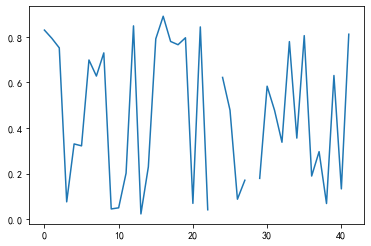

In [8]:
ndvi_arr2 = np.loadtxt(r"D:\Backup\Code\jupyter\SIF\返修论文画图\ndvi_arr.txt")


In [9]:
'''
存储为经过滤波后的ndvi数组
'''
ndvi_sg = np.zeros(ndvi_arr2.shape)
for i in range(ndvi_arr2.shape[0]):
    ndvi_list = np.array(ndvi_arr2[i,:]/10000.)
    index = np.where(ndvi_list > 1.0 )
    ndvi_list[index]=np.nan
    ndvi_sg[i,:] = reconstruction(ndvi_list)
np.savetxt(r"D:\Backup\Code\jupyter\SIF\返修论文画图\ndvi_sg.txt", ndvi_sg)

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


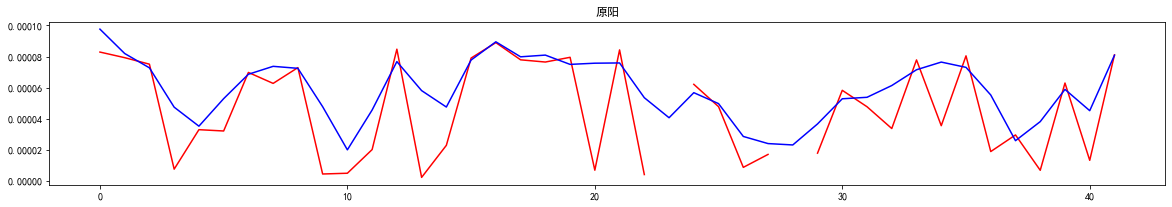

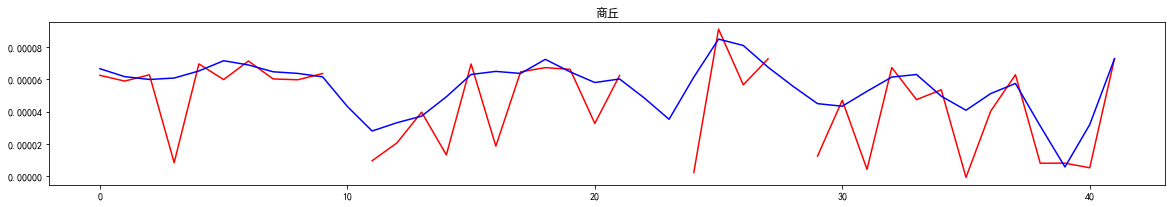

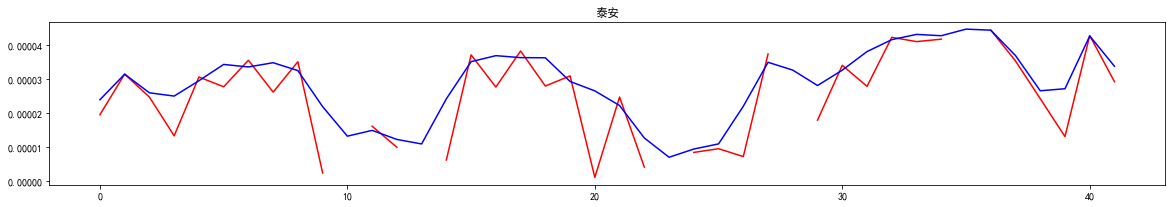

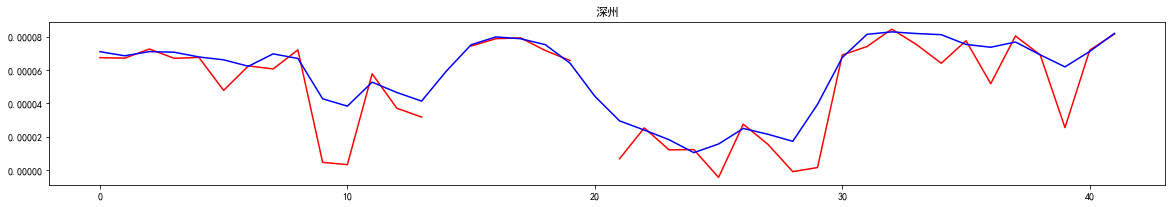

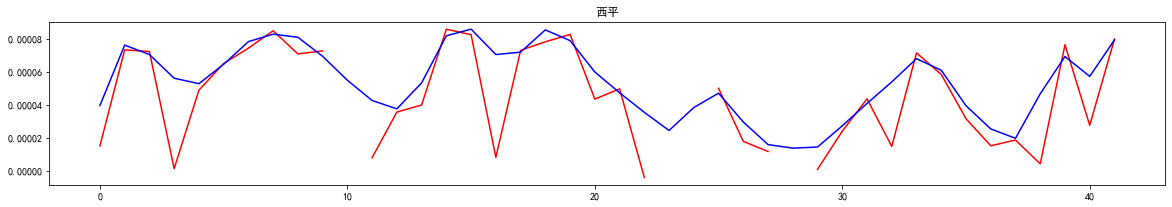

In [10]:
for city_i in range(0,5):
    city_name = city[city_i]
    ndvi_list = np.array(ndvi_arr2[city_i,:]/10000.)
    index = np.where(ndvi_list > 1.0 )
    ndvi_list[index]=np.nan
    ndvi_list2 = reconstruction(ndvi_list)
    fig,ax = plt.subplots(figsize=(20,3))
    ax.plot(ndvi_list,c='r')
    ax.plot(ndvi_list2,c='b')
    plt.title(city_name)

[0.43200821 0.60506332 0.40650082 0.33721474 0.67329139 0.71433967]
[0.61996514 0.53961974 0.57558948 0.4285773  0.63361895 0.7260412 ]
[0.52839071 0.490596   0.40595517 0.47147918 0.62177038 0.35679099]
[0.48190534 0.51273394 0.42451173 0.50590199 0.60898954 0.65431595]
[0.54958475 0.59048772 0.6956954  0.         0.64059901 0.71520936]


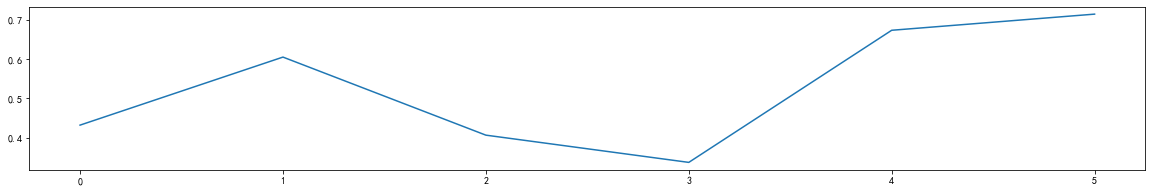

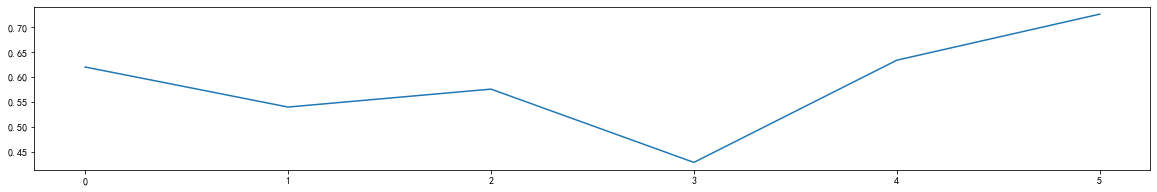

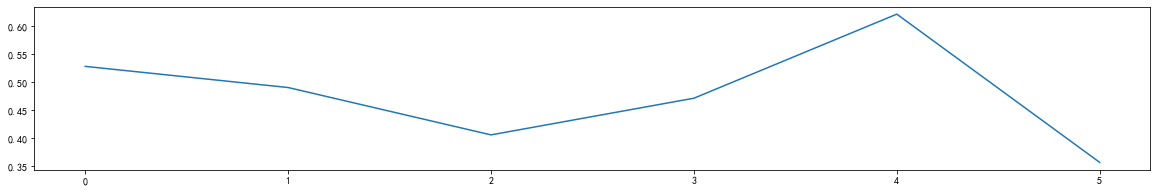

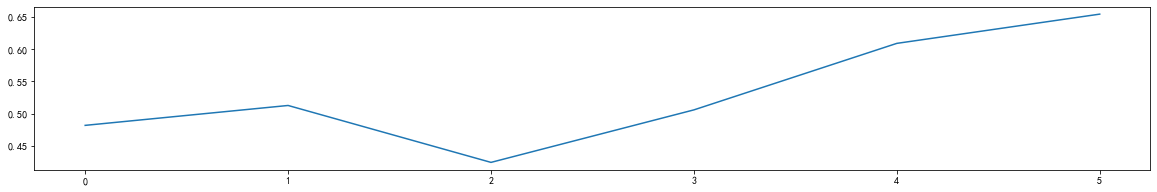

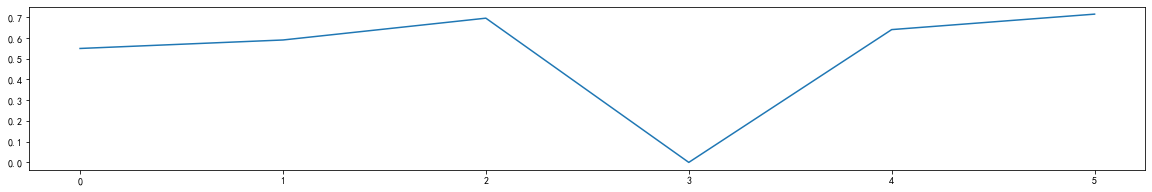

In [15]:
'''
将八天的TVDI时间序列读取存储为数组
'''
tvdi_list = glob(r"D:\RS_DATA\SIF\TROPO\论文更改分析\TVDI序列\resample\*.tif")
tvdi_length = len(tvdi_list)
dates_list = pd.date_range(start='3/30/2019',end='5/10/2019')
df_tvdi = pd.DataFrame(np.full((len(dates_list),5), np.nan), index=dates_list, columns=city)
#print(df_tvdi)
tvdi_dates_list = pd.date_range(start='3/30/2019',end='5/10/2019',freq='8d')
#print(tvdi_dates_list)
tvdi_arr = np.zeros((5,len(tvdi_list)),dtype=np.float64)
for jj in range(0,5):
    city_ = city[jj]
    y = lat[jj]
    x = lon[jj]
    coordinates = list([x,y])
    values = []
    for ii in range(0,tvdi_length):
        value = get_value_by_coordinates(tvdi_list[ii],coordinates,coordinates_type = "lonlat")
        values = np.append(values,value)
    tvdi_arr[jj,:]=values
    fig = plt.subplots(figsize=(20,3))
    plt.plot(tvdi_arr[jj,:])
    index = np.arange(0,48,8)
    print(tvdi_arr[jj,:])
    df_tvdi.iloc[index,jj]= tvdi_arr[jj,:]

In [16]:
df_tvdi.to_csv(r"D:\Backup\Code\jupyter\SIF\返修论文画图\tvdi.txt", sep='\t', header=None)

In [36]:
'''
将八天间隔的时间序列数据插补为逐日连续的，没有数据设为nan
'''
import pandas as pd
test = pd.date_range(start = '2019-03-30',end='2019-05-10',freq = 'D')
df = pd.DataFrame(np.full((len(test),5), np.nan), index=test, columns=['Pre','SM','TVDI','NDVI','NSDI'])


def get_date_list(begin_date,end_date):
    date_list = [x.strftime('%Y-%m-%d') for x in list(pd.date_range(start=begin_date, end=end_date))]
    return date_list

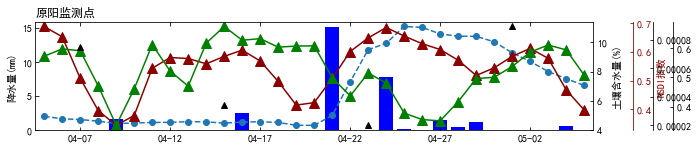

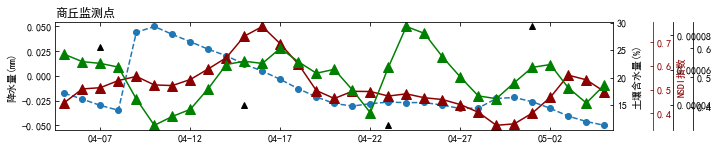

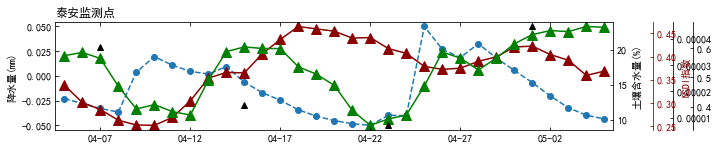

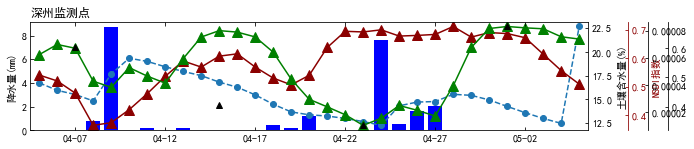

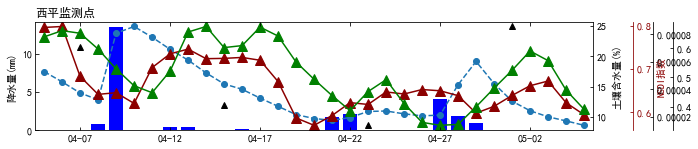

In [9]:
'''
正式画图
应包含3月30日至5月10日区间内
 -降水量
 -10cm土壤湿度
 -TVDI
 -NDVI
 -NSDI
五个参数的变化情况

逐个城市画图，修改城市索引j以及时间区间。
'''

for j in range(0,5):
    try:
        city_ = city[j]
        smc_file = smc_list[j]
        pre_file = pre_list[j]
        #df=pd.read_csv(smc_file,engine='python')
        df=pd.read_csv(smc_file)
        df_pre = pd.read_csv(pre_file)

        #设置时间区间，新建时间序列
        d_start = datetime(2019,3,30)
        d_1 = datetime(2019,4,5)
        d_2 = datetime(2019,5,5)
        interval_1 = d_1 - d_start
        interval_2 = d_2 - d_start
        d_1_year,d_1_month,d_1_day = d_1.year,d_1.month,d_1.day
        d_2_year,d_2_month,d_2_day = d_2.year,d_2.month,d_2.day

        #dates_list =  pd.date_range(start='4/01/2019', end='5/05/2019')
        dates_list =  pd.date_range(d_1, d_2)
        dates_list =  pd.to_datetime(dates_list)

        #读入SMC
        df = df.set_index(df.columns[0])
        df.index = df.index.map(pd.to_datetime)
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['day'] = df.index.day
        mean_data = df.groupby(['year','month','day'])['10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'].agg('mean')

        #读入Pre
        df_pre = df_pre.set_index(df_pre.columns[0])
        df_pre.index = df_pre.index.map(pd.to_datetime)
        df_pre['year'] = df_pre.index.year
        df_pre['month'] = df_pre.index.month
        df_pre['day'] = df_pre.index.day
        df_add_pre = df_pre.groupby(['year','month','day'])['precipitation'].sum()

        #读入NIBS
        NIBS_arr = np.zeros((5,len(tif_list)),dtype=np.float64)
        for i in range(0,5):
            y = lat[i]
            x = lon[i]
            coordinates = list([x,y])
            values = []
            for ii in range(0,tif_length):

                value = get_value_by_coordinates(tif_list[ii],coordinates,coordinates_type = "lonlat")
                values = np.append(values,value)
            NIBS_arr[i,:]=values

        #读入NDVI
        NDVI_arr = np.loadtxt(r"D:\Backup\Code\jupyter\SIF\返修论文画图\ndvi_sg.txt")

        #读入TVDI
        df_tvdi = pd.read_csv(r"D:\Backup\Code\jupyter\SIF\返修论文画图\TVDI.txt", sep='\t', header=None)
        df_tvdi = df_tvdi.set_index(df_tvdi.columns[0])
        df_tvdi.index = df_tvdi.index.map(pd.to_datetime)
        df_tvdi.columns= ['原阳', '商丘', '泰安', '深州', '西平'] 

        #画图
        fig = plt.figure(figsize=(10,2))
        host = host_subplot(111,axes_class=AA.Axes)
        host.set_ylabel('降水量(mm)')
        #host.xaxis.set_major_locator=(mdates.DayLocator())
        #host.xaxis.set_major_fomatter=(mdates.DateFormatter('%m-%d'))
        #plt.subplots_adjust(right=0.75)

        sm_ax = host.twinx()
        sm_ax.axis['right'].toggle(all=True)
        sm_ax.set_ylabel('土壤含水量(%)')


        #设置右面新纵轴的属性
        NIBS_ax = host.twinx()#设置一个新的axes，共享host的x轴
        new_fixed_axis = NIBS_ax.get_grid_helper().new_fixed_axis #设置新轴的属性函数
        NIBS_ax.axis['right'] = new_fixed_axis(loc='right',axes=NIBS_ax,offset=(40,0))#定义了一个新轴的名字是right
        NIBS_ax.axis['right'].toggle(all=True)
        NIBS_ax.axis['right'].line.set_color('darkred')
        NIBS_ax.axis['right'].major_ticks.set_color('darkred')
        NIBS_ax.axis['right'].label.set_color('darkred')
        NIBS_ax.axis['right'].major_ticklabels.set_color('darkred')
        NIBS_ax.set_ylabel('NSDI指数')


        NDVI_ax = host.twinx()
        new_fixed_axis = NDVI_ax.get_grid_helper().new_fixed_axis
        NDVI_ax.axis['right'] = new_fixed_axis(loc='right',axes=NDVI_ax,offset=(60,0))#定义了一个新轴的名字是right
        NDVI_ax.axis['right'].toggle(all=True)

        TVDI_ax = host.twinx()
        new_fixed_axis = TVDI_ax.get_grid_helper().new_fixed_axis
        TVDI_ax.axis['right'] = new_fixed_axis(loc='right',axes=TVDI_ax,offset=(80,0))#定义了一个新轴的名字是right
        TVDI_ax.axis['right'].toggle(all=True)


        #画图

        d_1_str = d_1.strftime("%Y,%m,%d")
        d_2_str = d_2.strftime("%Y,%m,%d")
        ln1 = host.bar(dates_list,df_add_pre[(d_1.year,d_1.month,d_1.day):(d_2.year,d_2.month,d_2.day)],color='b')

        ln2, = sm_ax.plot(dates_list,mean_data['10cm SMC(%)'][(d_1.year,d_1.month,d_1.day):(d_2.year,d_2.month,d_2.day)],linestyle='--',marker='o')

        ln3, = NDVI_ax.plot(dates_list,NDVI_arr[j,interval_1.days:interval_2.days+1],marker='^',markersize=10,color='Green')

        ln4, = TVDI_ax.plot(dates_list,df_tvdi[city[0]][d_1:d_2],linestyle='--',marker='^',color='Black')

        ln5, = NIBS_ax.plot(dates_list,NIBS_arr[j,interval_1.days:interval_2.days+1],marker='^',markersize=10,color='darkred')

        plt.xlim(d_1+timedelta(days=-0.5),d_2+timedelta(days=0.5))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
        #设置范围
        # plt.legend(handles=[ln1,ln2,ln3,ln4,ln5],
        #            labels=['降水量','10cm土壤含水量','20cm土壤含水量','30cm土壤含水量','NIBS指数'],
        #           fontsize = 'x-small')
        plt.title("%s监测点" %city_ ,loc = 'left')
        outname = city_ + "_物联网数据与NSDI指数变化情况2.png"
        plt.savefig(outpath+outname,dpi=300)
    except Exception as e:
        continue

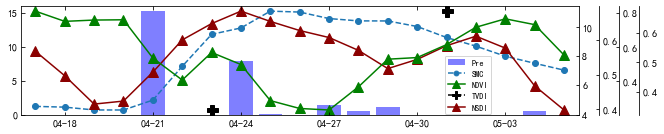

In [25]:
j=0
city_ = city[j]
smc_file = smc_list[j]
pre_file = pre_list[j]
#df=pd.read_csv(smc_file,engine='python')
df=pd.read_csv(smc_file)
df_pre = pd.read_csv(pre_file)

#设置时间区间，新建时间序列
d_start = datetime(2019,3,30)
d_1 = datetime(2019,4,17)
d_2 = datetime(2019,5,5)
interval_1 = d_1 - d_start
interval_2 = d_2 - d_start
d_1_year,d_1_month,d_1_day = d_1.year,d_1.month,d_1.day
d_2_year,d_2_month,d_2_day = d_2.year,d_2.month,d_2.day

#dates_list =  pd.date_range(start='4/01/2019', end='5/05/2019')
dates_list =  pd.date_range(d_1, d_2)
dates_list =  pd.to_datetime(dates_list)

#读入SMC
df = df.set_index(df.columns[0])
df.index = df.index.map(pd.to_datetime)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
mean_data = df.groupby(['year','month','day'])['10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'].agg('mean')

#读入Pre
df_pre = df_pre.set_index(df_pre.columns[0])
df_pre.index = df_pre.index.map(pd.to_datetime)
df_pre['year'] = df_pre.index.year
df_pre['month'] = df_pre.index.month
df_pre['day'] = df_pre.index.day
df_add_pre = df_pre.groupby(['year','month','day'])['precipitation'].sum()

#读入NIBS
NIBS_arr = np.zeros((5,len(tif_list)),dtype=np.float64)
for i in range(0,5):
    y = lat[i]
    x = lon[i]
    coordinates = list([x,y])
    values = []
    for ii in range(0,tif_length):

        value = get_value_by_coordinates(tif_list[ii],coordinates,coordinates_type = "lonlat")
        values = np.append(values,value)
    NIBS_arr[i,:]=values

#读入NDVI
NDVI_arr = np.loadtxt(r"D:\Backup\Code\jupyter\SIF\返修论文画图\ndvi_sg.txt")
NDVI_arr = NDVI_arr*10000.
#读入TVDI
df_tvdi = pd.read_csv(r"D:\Backup\Code\jupyter\SIF\返修论文画图\TVDI.txt", sep='\t', header=None)
df_tvdi = df_tvdi.set_index(df_tvdi.columns[0])
df_tvdi.index = df_tvdi.index.map(pd.to_datetime)
df_tvdi.columns= ['原阳', '商丘', '泰安', '深州', '西平'] 

#画图
fig = plt.figure(figsize=(10,2))
host = host_subplot(111,axes_class=AA.Axes)
#host.set_ylabel('降水量(mm)')
#host.xaxis.set_major_locator=(mdates.DayLocator())
#host.xaxis.set_major_fomatter=(mdates.DateFormatter('%m-%d'))
#plt.subplots_adjust(right=0.75)

sm_ax = host.twinx()
sm_ax.axis['right'].toggle(all=True)
#sm_ax.set_ylabel('土壤含水量(%)')


#设置右面新纵轴的属性
NIBS_ax = host.twinx()#设置一个新的axes，共享host的x轴
new_fixed_axis = NIBS_ax.get_grid_helper().new_fixed_axis #设置新轴的属性函数
NIBS_ax.axis['right'] = new_fixed_axis(loc='right',axes=NIBS_ax,offset=(20,0))#定义了一个新轴的名字是right
NIBS_ax.axis['right'].toggle(all=True)
# NIBS_ax.axis['right'].line.set_color('darkred')
# NIBS_ax.axis['right'].major_ticks.set_color('darkred')
# NIBS_ax.axis['right'].label.set_color('darkred')
# NIBS_ax.axis['right'].major_ticklabels.set_color('darkred')
# NIBS_ax.set_ylabel('NSDI指数')


NDVI_ax = host.twinx()
new_fixed_axis = NDVI_ax.get_grid_helper().new_fixed_axis
NDVI_ax.axis['right'] = new_fixed_axis(loc='right',axes=NDVI_ax,offset=(40,0))#定义了一个新轴的名字是right
NDVI_ax.axis['right'].toggle(all=True)
# NDVI_ax.set_ylabel('NDVI指数')

TVDI_ax = host.twinx()
new_fixed_axis = TVDI_ax.get_grid_helper().new_fixed_axis
TVDI_ax.axis['right'] = new_fixed_axis(loc='right',axes=TVDI_ax,offset=(60,0))#定义了一个新轴的名字是right
TVDI_ax.axis['right'].toggle(all=True)
# TVDI_ax.set_ylabel('TVDI指数')


#画图

d_1_str = d_1.strftime("%Y,%m,%d")
d_2_str = d_2.strftime("%Y,%m,%d")
ln1 = host.bar(dates_list,df_add_pre[(d_1.year,d_1.month,d_1.day):(d_2.year,d_2.month,d_2.day)],color='b',alpha=0.5)

ln2, = sm_ax.plot(dates_list,mean_data['10cm SMC(%)'][(d_1.year,d_1.month,d_1.day):(d_2.year,d_2.month,d_2.day)],linestyle='--',marker='o')

ln3, = NDVI_ax.plot(dates_list,NDVI_arr[j,interval_1.days:interval_2.days+1],marker='^',markersize=10,color='Green')

ln4, = TVDI_ax.plot(dates_list,df_tvdi[city[0]][d_1:d_2],linestyle='--',marker='P',markersize=11,color='Black')

ln5, = NIBS_ax.plot(dates_list,NIBS_arr[j,interval_1.days:interval_2.days+1],marker='^',markersize=10,color='darkred')

plt.xlim(d_1+timedelta(days=-0.5),d_2+timedelta(days=0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
#设置范围
plt.legend(handles=[ln1,ln2,ln3,ln4,ln5],
           loc = (0.76,0.01),
           labels=['Pre','SMC','NDVI','TVDI','NSDI'],
          fontsize = 'small',
          markerscale = 0.8)
#plt.title("%s监测点" %city_ ,loc = 'left')
#plt.tick_params(labelsize=25)
outname = city_ + "_NSDI指数在滞后性上的优势.png"
plt.savefig(outpath+outname,dpi=300)

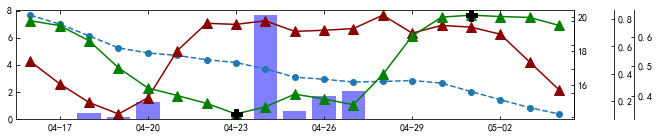

In [26]:
j=3
city_ = city[j]
smc_file = smc_list[j]
pre_file = pre_list[j]
#df=pd.read_csv(smc_file,engine='python')
df=pd.read_csv(smc_file)
df_pre = pd.read_csv(pre_file)

#设置时间区间，新建时间序列
d_start = datetime(2019,3,30)
d_1 = datetime(2019,4,16)
d_2 = datetime(2019,5,4)
interval_1 = d_1 - d_start
interval_2 = d_2 - d_start
d_1_year,d_1_month,d_1_day = d_1.year,d_1.month,d_1.day
d_2_year,d_2_month,d_2_day = d_2.year,d_2.month,d_2.day

#dates_list =  pd.date_range(start='4/01/2019', end='5/05/2019')
dates_list =  pd.date_range(d_1, d_2)
dates_list =  pd.to_datetime(dates_list)

#读入SMC
df = df.set_index(df.columns[0])
df.index = df.index.map(pd.to_datetime)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
mean_data = df.groupby(['year','month','day'])['10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'].agg('mean')

#读入Pre
df_pre = df_pre.set_index(df_pre.columns[0])
df_pre.index = df_pre.index.map(pd.to_datetime)
df_pre['year'] = df_pre.index.year
df_pre['month'] = df_pre.index.month
df_pre['day'] = df_pre.index.day
df_add_pre = df_pre.groupby(['year','month','day'])['precipitation'].sum()

#读入NIBS
NIBS_arr = np.zeros((5,len(tif_list)),dtype=np.float64)
for i in range(0,5):
    y = lat[i]
    x = lon[i]
    coordinates = list([x,y])
    values = []
    for ii in range(0,tif_length):

        value = get_value_by_coordinates(tif_list[ii],coordinates,coordinates_type = "lonlat")
        values = np.append(values,value)
    NIBS_arr[i,:]=values

#读入NDVI
NDVI_arr = np.loadtxt(r"D:\Backup\Code\jupyter\SIF\返修论文画图\ndvi_sg.txt")
NDVI_arr = NDVI_arr*10000.
#读入TVDI
df_tvdi = pd.read_csv(r"D:\Backup\Code\jupyter\SIF\返修论文画图\TVDI.txt", sep='\t', header=None)
df_tvdi = df_tvdi.set_index(df_tvdi.columns[0])
df_tvdi.index = df_tvdi.index.map(pd.to_datetime)
df_tvdi.columns= ['原阳', '商丘', '泰安', '深州', '西平'] 

#画图
fig = plt.figure(figsize=(10,2))
host = host_subplot(111,axes_class=AA.Axes)
#host.set_ylabel('降水量(mm)')
#host.xaxis.set_major_locator=(mdates.DayLocator())
#host.xaxis.set_major_fomatter=(mdates.DateFormatter('%m-%d'))
#plt.subplots_adjust(right=0.75)

sm_ax = host.twinx()
sm_ax.axis['right'].toggle(all=True)
#sm_ax.set_ylabel('土壤含水量(%)')


#设置右面新纵轴的属性
NIBS_ax = host.twinx()#设置一个新的axes，共享host的x轴
new_fixed_axis = NIBS_ax.get_grid_helper().new_fixed_axis #设置新轴的属性函数
NIBS_ax.axis['right'] = new_fixed_axis(loc='right',axes=NIBS_ax,offset=(20,0))#定义了一个新轴的名字是right
NIBS_ax.axis['right'].toggle(all=True)

# NIBS_ax.axis['right'].line.set_color('darkred')
# NIBS_ax.axis['right'].major_ticks.set_color('darkred')
# NIBS_ax.axis['right'].label.set_color('darkred')
# NIBS_ax.axis['right'].major_ticklabels.set_color('darkred')
# NIBS_ax.set_ylabel('NSDI指数')


NDVI_ax = host.twinx()
new_fixed_axis = NDVI_ax.get_grid_helper().new_fixed_axis
NDVI_ax.axis['right'] = new_fixed_axis(loc='right',axes=NDVI_ax,offset=(40,0))#定义了一个新轴的名字是right
NDVI_ax.axis['right'].toggle(all=True)
# NDVI_ax.set_ylabel('NDVI指数')

TVDI_ax = host.twinx()
new_fixed_axis = TVDI_ax.get_grid_helper().new_fixed_axis
TVDI_ax.axis['right'] = new_fixed_axis(loc='right',axes=TVDI_ax,offset=(60,0))#定义了一个新轴的名字是right
TVDI_ax.axis['right'].toggle(all=True)
# TVDI_ax.set_ylabel('TVDI指数')


#画图

d_1_str = d_1.strftime("%Y,%m,%d")
d_2_str = d_2.strftime("%Y,%m,%d")
ln1 = host.bar(dates_list,df_add_pre[(d_1.year,d_1.month,d_1.day):(d_2.year,d_2.month,d_2.day)],color='b',alpha=0.5)

ln2, = sm_ax.plot(dates_list,mean_data['20cm SMC(%)'][(d_1.year,d_1.month,d_1.day):(d_2.year,d_2.month,d_2.day)],linestyle='--',marker='o')

ln3, = NDVI_ax.plot(dates_list,NDVI_arr[j,interval_1.days:interval_2.days+1],marker='^',markersize=10,color='Green')

ln4, = TVDI_ax.plot(dates_list,df_tvdi[city[0]][d_1:d_2],linestyle='--',marker='P',markersize=11,color='Black')

ln5, = NIBS_ax.plot(dates_list,NIBS_arr[j,interval_1.days:interval_2.days+1],marker='^',markersize=10,color='darkred')

plt.xlim(d_1+timedelta(days=-0.5),d_2+timedelta(days=0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
#设置范围
# plt.legend(handles=[ln1,ln2,ln3,ln4,ln5],
#            loc = (0.76,0.01),
#            labels=['Pre','SMC','NDVI','TVDI','NSDI'],
#           fontsize = 'small',
#           markerscale = 0.8)
#plt.title("%s监测点" %city_ ,loc = 'left')
#plt.tick_params(labelsize=25)
outname = city_ + "_NSDI指数在滞后性上的优势2.png"
plt.savefig(outpath+outname,dpi=300)